In [1]:
import sys
import shutil
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import flopy

flopy is installed in /Users/langevin/langevin/dev/flopy3fork.git/flopy


In [2]:
# Path to the MODFLOW 6 repository
mf6path = '../../../modflow6-fork.git'
assert os.path.isdir(mf6path)

In [3]:
mf6exe = os.path.join(mf6path, 'bin', 'mf6')
mf6exe = os.path.abspath(mf6exe)
assert os.path.isfile(mf6exe)
print(mf6exe)

/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6


In [4]:
def get_model(ws, name, nlay=52, ncol=106,
              single_matrix=False, hhformulation=True,
              constant_concentration=False, general_head_boundary=False,
              ctimes=None, cidx=None, sptimes=None, verbosity_level=1,
              saverecord_concentration='ALL', runmodel=True):
    
    # model units are in cm/min

    lx = 53.
    lz = 26.

    nrow = 1
    delr = lx / ncol
    delc = 1.
    top = 26.
    delz = lz / nlay
    botm = list(top - np.arange(delz, nlay * delz + delz, delz))

    perlen = [60, 80, 60] # time is in minutes
    nper = len(perlen)
    nstp = [k * 60 for k in perlen]
    tsmult = nper * [1.]
    steady = nper * [True]
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))

    # This should be changed to one true and one false after scott fixes
    # flopy.
    nouter, ninner = 100, 300
    hclose, rclose, relax = 1e-4, 1e-2, 0.97

    # build MODFLOW 6 files
    sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                                 exe_name=mf6exe,
                                 verbosity_level=verbosity_level,
                                 sim_ws=ws)
    sim.name_file.continue_ = True
    
    # create tdis package
    tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                                 nper=nper, perioddata=tdis_rc)

    # create gwf model
    gwfname = 'gwf_' + name
    gwtname = 'gwt_' + name

    gwf = flopy.mf6.MFModel(sim, model_type='gwf6', modelname=gwfname,
                            model_nam_file='{}.nam'.format(gwfname))

    imsgwf = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                  outer_hclose=hclose,
                                  outer_maximum=nouter,
                                  under_relaxation='NONE',
                                  inner_maximum=ninner,
                                  inner_hclose=hclose, rcloserecord=rclose,
                                  linear_acceleration='BICGSTAB',
                                  scaling_method='NONE',
                                  reordering_method='NONE',
                                  relaxation_factor=relax,
                                  filename='{}.ims'.format(gwfname))
    if single_matrix:
        sim.register_ims_package(imsgwf, [gwfname, gwtname])
    else:
        sim.register_ims_package(imsgwf, [gwfname])

    dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm)

    # initial conditions
    ic = flopy.mf6.ModflowGwfic(gwf, strt=1.)

    # node property flow
    hk = 1050 # m/d
    hk = hk * 100. / 24. / 60. # cm/min
    npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=False,
                                  save_flows=True,
                                  save_specific_discharge=True,
                                  icelltype=0,
                                  k=hk)

    hhoptions = False
    drhodc = 0.7
    denseref = 1.0
    csalt = 0.0371
    if hhformulation:
        hhoptions = [('HHFORMULATION'), ]
        hhoptions.append(('LHS'))
    buy = flopy.mf6.ModflowGwfbuy(gwf, hhoptions=hhoptions,
                                  denseref=denseref, drhodc=drhodc)


    def ghb_value(k):
        salthead = 25.5
        z = 26 - (k * delz) + .5 * delz
        #depth = k * delz + 0.5 * delz
        f = csalt * drhodc
        if hhformulation:
            f = 0.
        hf = None
        if z < salthead:
            hf = salthead + f * (salthead - z)
        return hf

    # ghb or chd files
    if general_head_boundary:
        ghblist = []
        cond = hk * delz * delc / (delr / 2.0)
        for k in range(1, nlay):
            stage = ghb_value(k)
            if stage is not None:
                ghblist.append([(k, 0, 0), stage, cond, csalt, denseref + drhodc * csalt])
        ghb = flopy.mf6.ModflowGwfghb(gwf,
                                       stress_period_data=ghblist,
                                       print_input=True,
                                       print_flows=True,
                                       save_flows=False,
                                       pname='GHB-1',
                                       auxiliary=['CONCENTRATION', 'DENSITY'],
                                       filename='{}.ghb'.format(gwfname))
    else:
        chdlist1 = []
        for k in range(1, nlay):
            chdlist1.append([(k, 0, 0), 25.5, csalt, denseref + drhodc * csalt])
        chd1 = flopy.mf6.ModflowGwfchd(gwf,
                                       stress_period_data=chdlist1,
                                       print_input=True,
                                       print_flows=True,
                                       save_flows=False,
                                       pname='CHD-LEFT',
                                       auxiliary=['CONCENTRATION', 'DENSITY'],
                                       filename='{}-left.chd'.format(gwfname))

    head_by_stress_period = [26.7, 26.2, 26.55]
    chd2spd = {}
    for kper, chdval in enumerate(head_by_stress_period):
        chdlist2 = []
        for k in range(nlay):
            chdlist2.append([(k, 0, ncol - 1), chdval, 0.])
        chd2spd[kper] = chdlist2
    chd2 = flopy.mf6.ModflowGwfchd(gwf,
                                   stress_period_data=chd2spd,
                                   print_input=True,
                                   print_flows=True,
                                   save_flows=False,
                                   pname='CHD-RIGHT',
                                   auxiliary='CONCENTRATION',
                                   filename='{}-right.chd'.format(gwfname))


    # output control
    oc = flopy.mf6.ModflowGwfoc(gwf,
                                budget_filerecord='{}.cbc'.format(gwfname),
                                head_filerecord='{}.hds'.format(gwfname),
                                headprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=[('HEAD', 'LAST'),
                                            ('BUDGET', 'LAST')],
                                printrecord=[('HEAD', 'LAST'),
                                             ('BUDGET', 'LAST')])

    # create gwt model
    gwt = flopy.mf6.MFModel(sim, model_type='gwt6', modelname=gwtname,
                            model_nam_file='{}.nam'.format(gwtname))

    if not single_matrix:
        imsgwt = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                      outer_hclose=1.e-8,
                                      outer_maximum=nouter,
                                      under_relaxation='NONE',
                                      inner_maximum=ninner,
                                      inner_hclose=hclose, rcloserecord=rclose,
                                      linear_acceleration='BICGSTAB',
                                      scaling_method='NONE',
                                      reordering_method='NONE',
                                      relaxation_factor=relax,
                                      filename='{}.ims'.format(gwtname))
        sim.register_ims_package(imsgwt, [gwt.name])

    dis = flopy.mf6.ModflowGwtdis(gwt, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm)

    # initial conditions
    strt = np.zeros((nlay, nrow, ncol), dtype=np.float)
    #strt[30:, :, 0] = csalt
    ic = flopy.mf6.ModflowGwtic(gwt, strt=strt)

    # advection
    adv = flopy.mf6.ModflowGwtadv(gwt, scheme='UPSTREAM',
                                  filename='{}.adv'.format(gwtname))

    # dispersion
    #diffc = 0.57024
    #dsp = flopy.mf6.ModflowGwtdsp(gwt, xt3d=False, diffc=diffc,
    #                              # alh=0., alv=0., ath=0., atv=0.,
    #                              filename='{}.dsp'.format(gwtname))

    # mass storage and transfer
    porosity = 0.385
    mst = flopy.mf6.ModflowGwtmst(gwt, porosity=porosity,
                                  filename='{}.sto'.format(gwtname))

    # sources
    if general_head_boundary:
        leftbnd = 'GHB-1'
    else:
        leftbnd = 'CHD-LEFT'
    sourcerecarray = [(leftbnd, 'AUX', 'CONCENTRATION'),
                      ('CHD-RIGHT', 'AUX', 'CONCENTRATION')]
    ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray,
                                  filename='{}.ssm'.format(gwtname))
    
    # constant concentration
    if constant_concentration:
        cnclist = []
        for k in range(1, nlay):
            cnclist.append([(k, 0, 0), 0.0371])
        cnc = flopy.mf6.ModflowGwtcnc(gwt, stress_period_data=cnclist)

    # output control
    saverecord = {}
    saverecord[0] = [('CONCENTRATION', 'LAST')]
    saverecord[1] = [('CONCENTRATION', 'STEPS', 5 * 60, 15 * 60, 55 * 60), 
                     ('CONCENTRATION', 'LAST')]
    saverecord[2] = [('CONCENTRATION', 'STEPS', 10 * 60, 15 * 60, 25 * 60), 
                     ('CONCENTRATION', 'LAST')]
    oc = flopy.mf6.ModflowGwtoc(gwt,
                                budget_filerecord='{}.cbc'.format(gwtname),
                                concentration_filerecord='{}.ucn'.format(
                                    gwtname),
                                concentrationprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=saverecord,
                                printrecord=[('CONCENTRATION', 'LAST'),
                                             ('BUDGET', 'LAST')])

    # GWF GWT exchange
    gwfgwt = flopy.mf6.ModflowGwfgwt(sim, exgtype='GWF6-GWT6',
                                     exgmnamea=gwfname, exgmnameb=gwtname,
                                     filename='{}.gwfgwt'.format(name))

    sim.write_simulation()
    if not runmodel:
        return sim
    
    v = sim.run_simulation(report=True)
    for idx in range(-3, 0):
        print(v[1][idx])
    
    fname = os.path.join(ws, 'gwt_' + name + '.ucn')
    concobj = flopy.utils.HeadFile(fname, text='concentration', precision='double')
    clist = None
    cts = None
    if ctimes is not None:
        times = concobj.get_times()
        clist = []
        for t in ctimes:
            if isinstance(t, str):
                if t.upper() == 'LAST':
                    tt = times[-1]
                    conc = concobj.get_data(totim=tt)
            else:
                conc = concobj.get_data(totim=t)
            clist.append(conc)
    if cidx is not None:
        cts = concobj.get_ts(cidx)
    concobj.file.close()

    fname = os.path.join(ws, 'gwf_' + name + '.cbc')
    budobj = flopy.utils.CellBudgetFile(fname, precision='double')
    splist = None
    if sptimes is not None:
        times = budobj.get_times()
        splist = []
        for t in sptimes:
            if isinstance(t, str):
                if t.upper() == 'LAST':
                    tt = times[-1]
                    spdis = budobj.get_data(totim=tt, text='DATA-SPDIS')[0]
            else:
                spdis = budobj.get_data(totim=t, text='DATA-SPDIS')[0]
            splist.append(spdis)    
    
    return sim, clist, cts, splist

In [5]:
levels = [.2]
plot_grid = False
plot_title = False
xlabel = 'DISTANCE, IN CENTIMETERS'
ylabel = 'ELEVATION, IN CENTIMETERS'

## MODFLOW 6 Hydraulic Head Formulation

In [6]:
# Hydraulic Head formulation
ws = 'temp/pxx_goswami'
name = 'goswami'
gfact = 1
sim, clist, cts, splist = get_model(ws, name, nlay=gfact*52, ncol=gfact*106,
                                    hhformulation=True,
                                    verbosity_level=0,
                                    constant_concentration=False,
                                    general_head_boundary=True,
                                    ctimes=['last'], sptimes=['last'])
mf6hhconc = clist[0]

 Elapsed run time:  1 Minutes, 47.826 Seconds

 Normal termination of simulation.


In [7]:
ws = 'temp/pxx_goswami'
name = 'goswami'
fname = os.path.join(ws, 'gwt_' + name + '.ucn')
concobj = flopy.utils.HeadFile(fname, text='concentration', precision='double')
cclist = []
for kstpkper in [(60*60 - 1, 0), (80*60 - 1, 1), (60*60 - 1, 2)]:
    c = concobj.get_data(kstpkper=kstpkper)
    cclist.append(c)

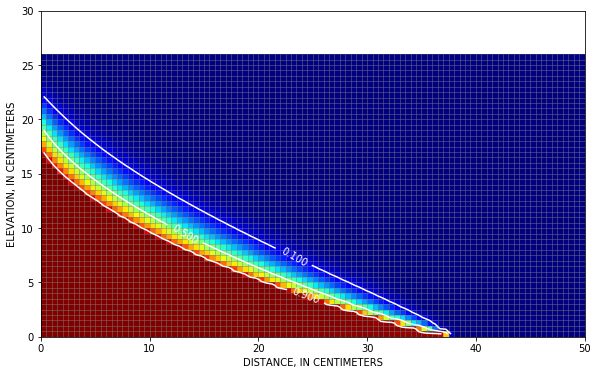

In [8]:
gwf = sim.get_model('gwf_' + name)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
xs = flopy.plot.PlotCrossSection(gwf, line={'row': 0})
xs.plot_grid(linewidths=0.5, alpha=0.5)
xs.plot_array(cclist[1], cmap='jet', vmin=0, vmax=0.0371)
#xs.plot_specific_discharge(splist[0], color='white')
cs = xs.contour_array(cclist[1] / 0.0371, levels=[0.1, .5, .9], colors='white')
ax.clabel(cs)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_xlim(0, 50.)
ax.set_ylim(0, 30.)
if plot_title:
    ax.set_title('MODFLOW 6 HYDRAULIC HEAD FORMULATION')

In [9]:
# table A1 from Goswami and Clement (2007)
ss1x = [0, .2, 1, 1.9, 2.8, 4, 5, 6.3, 7.5, 8.7, 10.1, 11.6, 13.1, 15.1]
ss1z = [13.2, 12.5, 11.5, 10.5, 9.5, 8.5, 7.5, 6.5, 5.5, 4.5, 3.5, 2.5, 1.5, 0.5]
ss2x = [0, 0.4, 1.1, 1.9, 3., 4.3, 5.7, 7.4, 9., 10.7, 12.6, 14.4, 16.2, 18.1, 
        19.9, 21.9, 23.9, 26., 28.3, 30.5, 32.9, 35.2, 37.6]
ss2z = [22., 21.5, 20.5, 19.5, 18.5, 17.5, 16.5, 15.5, 14.5, 13.5, 
        12.5, 11.5, 10.5, 9.5, 8.5, 7.5, 6.5, 5.5, 4.5, 3.5, 2.5, 1.5, 0.5]
ss3x = [0, 0.6, 1.5, 2.3, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 10.1, 11.6, 13.1, 14.7, 16.2, 18.2]
ss3z = [15.5, 14.5, 13.5, 12.5, 11.5, 10.5, 9.5, 8.5, 7.5, 6.5, 5.5, 4.5, 3.5, 2.5, 1.5, 0.5]

inwidth 3.248031496062992


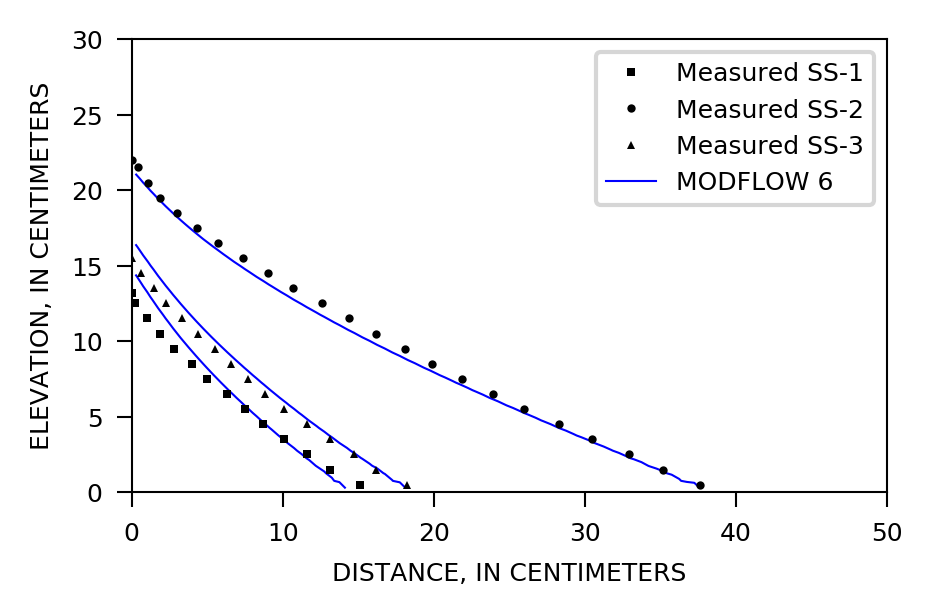

In [11]:
# Figure 5 from Goswami and Clement (2007)

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

def ax_formatter(ax):
    for tick in ax.xaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')    
    for tick in ax.yaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')
    ax.set_aspect(1.)
    ax.set_xticks([0, 10, 20, 30, 40, 50])
    ax.set_yticks([0, 5, 10, 15, 20, 25, 30])
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)

cmwidth = 8.25 # Groundwater 1 column width figure size
inwidth = cmwidth / 2.54
print('inwidth {}'.format(inwidth))
fig = plt.figure(figsize=(inwidth, 6.5), dpi=300)


fname = os.path.join(ws, 'gwt_' + name + '.ucn')
concobj = flopy.utils.HeadFile(fname, text='concentration', precision='double')
cclist = []
for kstpkper in [(60*60 - 1, 0), (80*60 - 1, 1), (60*60 - 1, 2)]:
    c = concobj.get_data(kstpkper=kstpkper)
    cclist.append(c)
concobj.file.close()

gwf = sim.get_model('gwf_' + name)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax_formatter(ax)
xs = flopy.plot.PlotCrossSection(gwf, line={'row': 0}, ax=ax)
if plot_grid:
    xs.plot_grid(linewidths=0.5, alpha=0.5)

levels = [0.2]
cs = xs.contour_array(cclist[0] / 0.0371, levels=levels, colors='blue', linewidths=0.5)
cs = xs.contour_array(cclist[1] / 0.0371, levels=levels, colors='blue', linewidths=0.5)
cs = xs.contour_array(cclist[2] / 0.0371, levels=levels, colors='blue', linewidths=0.5)

h1 = plt.plot(ss1x, ss1z, marker='s', ms=2.0, mfc='k', mec='none', linestyle='none', label='Measured SS-1')[0]
h2 = plt.plot(ss2x, ss2z, marker='o', ms=2.0, mfc='k', mec='none', linestyle='none', label='Measured SS-2')[0]
h3 = plt.plot(ss3x, ss3z, marker='^', ms=2.0, mfc='k', mec='none', linestyle='none', label='Measured SS-3')[0]

black_line = mlines.Line2D([], [], color='blue', label='MODFLOW 6', lw=0.5)
handles = [h1, h2, h3, blue_line]
labels = [h1.get_label(), h2.get_label(), h3.get_label(), black_line.get_label()]
plt.legend(handles, labels, fontsize=6)

ax.set_xlim(0, 50.)
ax.set_ylim(0, 30.)

#ax.clabel(cs)
ax.set_xlabel(xlabel, fontsize=6)
ax.set_ylabel(ylabel, fontsize=6)
if plot_title:
    ax.set_title('STEADY-STATE POSITIONS (SS1, SS2, SS3)', fontsize=6)

fname = '../Figures/pxx_goswami5.pdf'
plt.savefig(fname, bbox_inches='tight')

inwidth 3.248031496062992


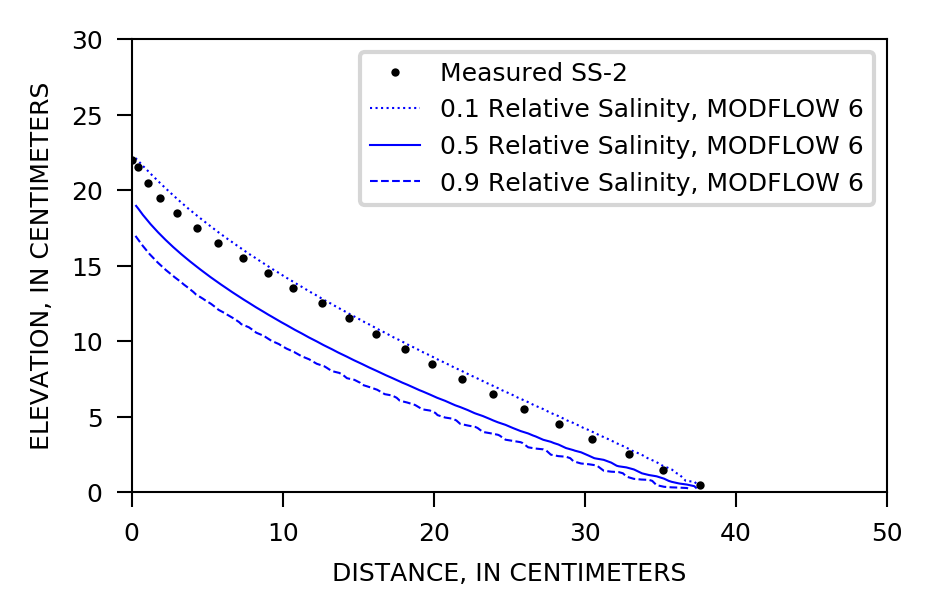

In [12]:
# Figure 6 from Goswami and Clement (2007)

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

def ax_formatter(ax):
    for tick in ax.xaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')    
    for tick in ax.yaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')
    ax.set_aspect(1.)
    ax.set_xticks([0, 10, 20, 30, 40, 50])
    ax.set_yticks([0, 5, 10, 15, 20, 25, 30])
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)

cmwidth = 8.25 # Groundwater 1 column width figure size
inwidth = cmwidth / 2.54
print('inwidth {}'.format(inwidth))
fig = plt.figure(figsize=(inwidth, 6.5), dpi=300)


gwf = sim.get_model('gwf_' + name)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax_formatter(ax)
xs = flopy.plot.PlotCrossSection(gwf, line={'row': 0}, ax=ax)
if plot_grid:
    xs.plot_grid(linewidths=0.5, alpha=0.5)

cs = xs.contour_array(cclist[1] / 0.0371, levels=[0.1, .5, .9], 
                      linestyles = [':', '-', '--'], colors='blue', linewidths=0.5)

h2 = plt.plot(ss2x, ss2z, marker='o', ms=2.0, mfc='k', mec='none', linestyle='none', label='Measured SS-2')[0]
dot_line = mlines.Line2D([], [], linestyle=':', color='blue', lw=0.5, label='0.1 Relative Salinity, MODFLOW 6')
black_line = mlines.Line2D([], [], color='blue', lw=0.5, label='0.5 Relative Salinity, MODFLOW 6')
dash_line = mlines.Line2D([], [], linestyle='--', color='blue', lw=0.5, label='0.9 Relative Salinity, MODFLOW 6')

handles = [h2, dot_line, black_line, dash_line]
labels = [h2.get_label(), dot_line.get_label(), black_line.get_label(), dash_line.get_label()]
plt.legend(handles, labels, fontsize=6)

ax.set_xlim(0, 50.)
ax.set_ylim(0, 30.)

#ax.clabel(cs)
ax.set_xlabel(xlabel, fontsize=6)
ax.set_ylabel(ylabel, fontsize=6)
if plot_title:
    ax.set_title('STEADY-STATE POSITIONS (SS1, SS2, SS3)')

fname = '../Figures/pxx_goswami6.pdf'
plt.savefig(fname, bbox_inches='tight')

In [13]:
# transient advancing (Table A2, Figure 7, Goswami) at 5, 15, and 55 min
ta5x = [0, .3, .9, 1.5, 2.2, 3, 4.1, 5.1, 6.2, 7.4, 8.6, 9.7, 11, 12.3, 13.7, 15.2, 16.8, 18.4, 20.1, 21.5]
ta5z = [19.3, 18.5, 17.5, 16.5, 15.5, 14.5, 13.5, 12.5, 11.5, 10.5, 9.5, 8.5, 7.5, 6.5, 5.5, 4.5, 3.5, 2.5, 1.5, 0.5]
ta15x = [0, 0.6, 1.4, 2.2, 3.2, 4.4, 5.6, 6.9, 8.2, 9.4, 10.7, 12.2, 13.7, 15.3, 17., 18.7, 20.6, 22.6, 24.8, 27, 29]
ta15z = [20.6, 19.5, 18.5, 17.5, 16.5, 15.5, 14.5, 13.5, 12.5, 11.5, 10.5, 9.5, 8.5, 7.5, 6.5, 5.5, 4.5, 3.5, 2.5, 1.5, 0.5]
ta55x = [0, 0.6, 1.4, 2.4, 3.7, 5.3, 7, 8.5, 10.1, 11.7, 13.4, 15.2, 17.2, 19.1, 21.2, 23.3, 25.4, 27.5, 29.7, 32, 34.5, 35.9]
ta55z = [21.6, 20.5, 19.5, 18.5, 17.5, 16.5, 15.5, 14.5, 13.5, 12.5, 11.5, 10.5, 9.5, 8.5, 7.5, 6.5, 5.5, 4.5, 3.5, 2.5, 1.5, 1.]

inwidth 3.248031496062992


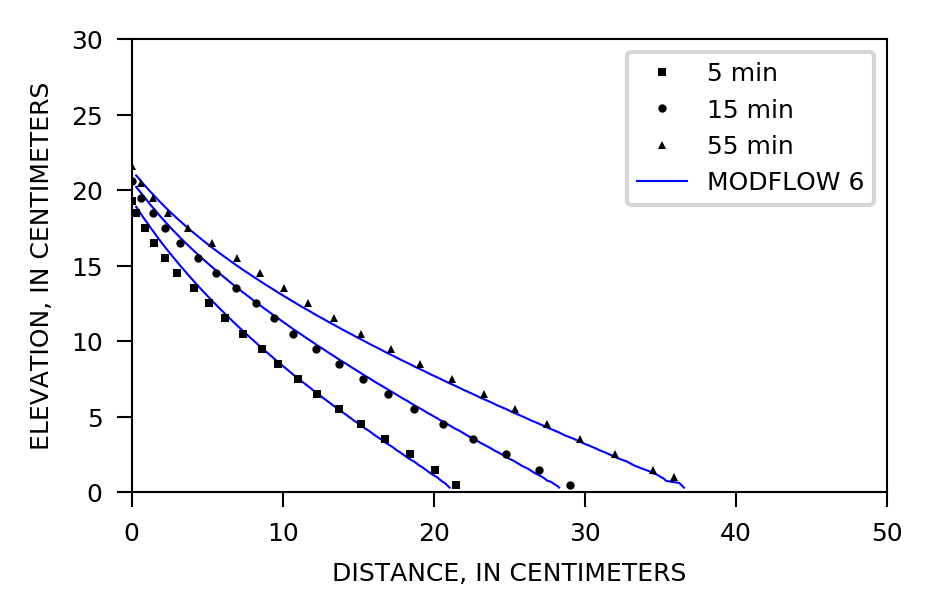

In [14]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

def ax_formatter(ax):
    for tick in ax.xaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')    
    for tick in ax.yaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')
    ax.set_aspect(1.)
    ax.set_xticks([0, 10, 20, 30, 40, 50])
    ax.set_yticks([0, 5, 10, 15, 20, 25, 30])
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)

cmwidth = 8.25 # Groundwater 1 column width figure size
inwidth = cmwidth / 2.54
print('inwidth {}'.format(inwidth))
fig = plt.figure(figsize=(inwidth, 6.5), dpi=300)

fname = os.path.join(ws, 'gwt_' + name + '.ucn')
concobj = flopy.utils.HeadFile(fname, text='concentration', precision='double')
cclist = []
for kstpkper in [(5*60 - 1, 1), (15*60 - 1, 1), (55*60 - 1, 1)]:
    c = concobj.get_data(kstpkper=kstpkper)
    cclist.append(c)
concobj.file.close()
    
gwf = sim.get_model('gwf_' + name)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax_formatter(ax)
xs = flopy.plot.PlotCrossSection(gwf, line={'row': 0}, ax=ax)
if plot_grid:
    xs.plot_grid(linewidths=0.5, alpha=0.5)

cs = xs.contour_array(cclist[0] / 0.0371, levels=levels, colors='blue', linewidths=0.5)
cs = xs.contour_array(cclist[1] / 0.0371, levels=levels, colors='blue', linewidths=0.5)
cs = xs.contour_array(cclist[2] / 0.0371, levels=levels, colors='blue', linewidths=0.5)

h1 = plt.plot(ta5x, ta5z, marker='s', ms=2., mfc='k', mec='none', linestyle='none', label='5 min')[0]
h2 = plt.plot(ta15x, ta15z, marker='o', ms=2., mfc='k', mec='none', linestyle='none', label='15 min')[0]
h3 = plt.plot(ta55x, ta55z, marker='^', ms=2., mfc='k', mec='none', linestyle='none', label='55 min')[0]
blue_line = mlines.Line2D([], [], color='blue', lw=0.5, label='MODFLOW 6')
handles = [h1, h2, h3, blue_line]
labels = [h1.get_label(), h2.get_label(), h3.get_label(), blue_line.get_label()]
plt.legend(handles, labels, fontsize=6)

ax.set_xlim(0, 50.)
ax.set_ylim(0, 30.)

#ax.clabel(cs)
ax.set_xlabel(xlabel, fontsize=6)
ax.set_ylabel(ylabel, fontsize=6)
if plot_title:
    ax.set_title('TRANSIENT ADVANCING SALT WEDGE')

fname = '../Figures/pxx_goswami7.pdf'
plt.savefig(fname, bbox_inches='tight')

In [15]:
# transient receding (Table A3, Figure 8, Goswami) at 10, 15, and 25 min
tr10x = [0, 0.7, 1.6, 2.5, 3.6, 4.8, 6, 7.5, 9, 10.5, 12.1, 13.8, 15.4, 17.1, 18.9, 20.7, 22.1, 24.7, 26.6]
tr10z = [18.8, 17.5, 16.5, 15.5, 14.5, 13.5, 12.5, 11.5, 10.5, 9.5, 8.5, 7.5, 6.5, 5.5, 4.5, 3.5, 2.5, 1.5, 0.5]
tr15x = [0, 0.2, 0.7, 1.6, 2.6, 3.7, 4.8, 6, 7.35, 8.65, 10, 11.4, 12.9, 14.4, 15.9, 17.45, 19.15, 21, 23.1]
tr15z = [18.3, 17.5, 16.5, 15.5, 14.5, 13.5, 12.5, 11.5, 10.5, 9.5, 8.5, 7.5, 6.5, 5.5, 4.5, 3.5, 2.5, 1.5, 0.5]
tr25x = [0, 0.6, 1.5, 2.5, 3.6, 4.7, 5.8, 6.9, 8, 9.1, 10.2, 11.5, 13, 14.5, 16, 17.7, 19.4]
tr25z = [16.7, 15.5, 14.5, 13.5, 12.5, 11.5, 10.5, 9.5, 8.5, 7.5, 6.5, 5.5, 4.5, 3.5, 2.5, 1.5, 0.5]

inwidth 3.248031496062992


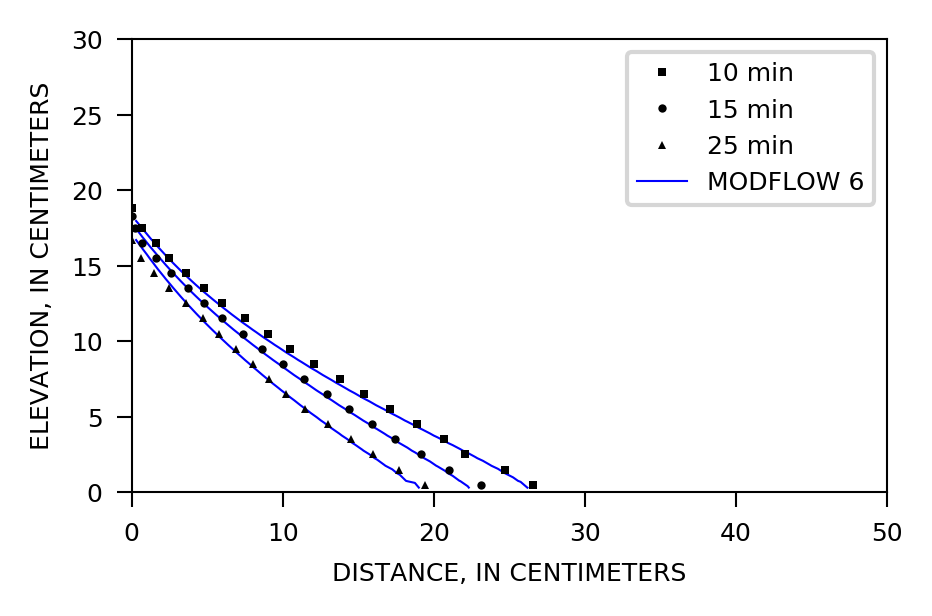

In [16]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

def ax_formatter(ax):
    for tick in ax.xaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')    
    for tick in ax.yaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')
    ax.set_aspect(1.)
    ax.set_xticks([0, 10, 20, 30, 40, 50])
    ax.set_yticks([0, 5, 10, 15, 20, 25, 30])
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)

cmwidth = 8.25 # Groundwater 1 column width figure size
inwidth = cmwidth / 2.54
print('inwidth {}'.format(inwidth))
fig = plt.figure(figsize=(inwidth, 6.5), dpi=300)

fname = os.path.join(ws, 'gwt_' + name + '.ucn')
concobj = flopy.utils.HeadFile(fname, text='concentration', precision='double')
cclist = []
for kstpkper in [(10*60 - 1, 2), (15*60 - 1, 2), (25*60 - 1, 2)]:
    c = concobj.get_data(kstpkper=kstpkper)
    cclist.append(c)
concobj.file.close()
    
gwf = sim.get_model('gwf_' + name)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax_formatter(ax)
xs = flopy.plot.PlotCrossSection(gwf, line={'row': 0}, ax=ax)
if plot_grid:
    xs.plot_grid(linewidths=0.5, alpha=0.5)

cs = xs.contour_array(cclist[0] / 0.0371, levels=levels, colors='blue', linewidths=0.5)
cs = xs.contour_array(cclist[1] / 0.0371, levels=levels, colors='blue', linewidths=0.5)
cs = xs.contour_array(cclist[2] / 0.0371, levels=levels, colors='blue', linewidths=0.5)

h1 = plt.plot(tr10x, tr10z, marker='s', ms=2., mfc='k', mec='none', linestyle='none', label='10 min')[0]
h2 = plt.plot(tr15x, tr15z, marker='o', ms=2., mfc='k', mec='none', linestyle='none', label='15 min')[0]
h3 = plt.plot(tr25x, tr25z, marker='^', ms=2., mfc='k', mec='none', linestyle='none', label='25 min')[0]
blue_line = mlines.Line2D([], [], color='blue', lw=0.5, label='MODFLOW 6')
handles = [h1, h2, h3, blue_line]
labels = [h1.get_label(), h2.get_label(), h3.get_label(), blue_line.get_label()]
plt.legend(handles, labels, fontsize=6)

ax.set_xlim(0, 50.)
ax.set_ylim(0, 30.)

#ax.clabel(cs)
ax.set_xlabel(xlabel, fontsize=6)
ax.set_ylabel(ylabel, fontsize=6)
if plot_title:
    ax.set_title('TRANSIENT RECEDING SALT WEDGE')

fname = '../Figures/pxx_goswami8.pdf'
plt.savefig(fname, bbox_inches='tight')

In [17]:
# laboratory measured and simulated flows from the freshwater boundary for SS-1, SS-2, and SS-3
qss1 = 1.42 #cm^3/s
qss2 = 0.59 #cm^3/s
qss3 = 1.19 #cm^3/s

qss1mf6 = 31.3434 #cm^3/cm/min
qss2mf6 = 13.3926 #cm^3/cm/min
qss3mf6 = 25.9574 #cm^3/cm/min

fact = 2.7 / 60
print('SS-1: ', qss1, '{:.2f}'.format(qss1mf6 * fact))
print('SS-2: ', qss2, '{:.2f}'.format(qss2mf6 * fact))
print('SS-3: ', qss3, '{:.2f}'.format(qss3mf6 * fact))

SS-1:  1.42 1.41
SS-2:  0.59 0.60
SS-3:  1.19 1.17
